In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
import os
os.chdir('/content/drive/MyDrive/Taxi-Cancellations-prediction')
!pwd

Mounted at /content/drive
/content
/content/drive/MyDrive/Taxi-Cancellations-prediction


# Load Libraries

In [85]:
!export QT_QPA_PLATFORM=linuxfb

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from math import sqrt, isnan, radians, sin, cos, acos

In [3]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# DATA PREPROCESSING

## Read data

In [4]:
df=pd.read_csv('Kaggle_YourCabs_training.csv',encoding='utf-8',engine='python')
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0


In [54]:
len(df[df['Car_Cancellation']==1])

3117

In [55]:
df.shape

(43255, 19)

In [56]:
df.describe()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
count,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000,43255.000000
mean,0.630011,0.274267,0.171495,0.508754,0.064706,0.441591,1.414923,0.036666,0.290567,0.350526,0.043070,0.072061,7.994662,0.034609,0.791492,0.173899,0.002451,0.997434,0.000116
std,0.225464,0.297559,0.101230,0.299714,0.068508,0.496582,3.919686,0.187943,0.155608,0.477140,0.203017,0.258592,25.340782,0.182789,0.406246,0.379027,0.049443,0.050593,0.010751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.954167,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.504506,0.122222,0.171667,0.279086,0.055276,0.000000,0.120139,0.000000,0.165552,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,0.648253,0.122222,0.171667,0.421128,0.055276,0.000000,0.364583,0.000000,0.290970,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.802747,0.255556,0.171667,0.775874,0.055276,1.000000,0.763889,0.000000,0.399666,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,0.998707,1.000000,1.000000,1.000000,1.000000,1.000000,79.454167,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43255 entries, 0 to 43342
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              43255 non-null  float64
 1   vehicle_model_id     43255 non-null  float64
 2   package_id           43255 non-null  float64
 3   from_area_id         43255 non-null  float64
 4   to_city_id           43255 non-null  float64
 5   small_diff_in_days   43255 non-null  int64  
 6   diff_in_days         43255 non-null  float64
 7   On_holidays          43255 non-null  int64  
 8   dist_in_km           43255 non-null  float64
 9   online_booking       43255 non-null  int64  
 10  mobile_site_booking  43255 non-null  int64  
 11  Car_Cancellation     43255 non-null  int64  
 12  Cost_of_error        43255 non-null  float64
 13  travel_type_1        43255 non-null  int64  
 14  travel_type_2        43255 non-null  int64  
 15  travel_type_3        43255 non-null 

## Drop useless columns

**The following columns will be removed**

1) The id column is unique for each driver so it is removed below

2) The to_date column is useless and it is removed as well

In [5]:
df=df.drop(['id','to_date'],axis=1)


## Replace NaN values with the average value of non-NaN values in package_id

In [8]:
count = 0
j=0
for i in df['package_id']:
    if not(math.isnan(i)):
        j+=1
        count+=i
package_mean=round(count/j,2)
df['package_id'].fillna(package_mean, inplace = True)
df

,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
0,22177,28,2.03,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750,0,1.0
1,21413,12,2.03,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640,0,1.0
2,22178,12,2.03,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766,0,1.0
3,13034,12,2.03,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140,0,1.0
4,22180,12,2.03,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,14364,12,2.03,2,1147.0,452.0,15.0,NaN,11/24/2013 18:00,1,0,11/24/2013 14:25,13.030640,77.649100,12.952780,77.590880,0,1.0
43427,48727,12,2.03,2,393.0,466.0,15.0,NaN,11/26/2013 1:00,1,0,11/24/2013 14:30,13.199560,77.706880,13.017436,77.644580,0,1.0
43428,48729,12,1.00,3,974.0,NaN,15.0,NaN,11/24/2013 18:30,0,0,11/24/2013 14:35,13.075570,77.559040,NaN,NaN,0,1.0
43429,30724,87,2.03,2,1263.0,542.0,15.0,NaN,11/24/2013 16:00,0,0,11/24/2013 14:43,12.968970,77.594560,12.938230,77.622890,0,1.0


## Preprocessing for user_id

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df[['user_id']])
df_normalized = pd.DataFrame(np_scaled)
df['user_id'] = df_normalized

## ONE-HOT ENCONDING FOR TRAVEL_TYPE_ID

In [13]:
#ONE-HOT ENCONDING FOR TRAVEL_TYPE_ID
oh_travel_type_id = pd.get_dummies(df.travel_type_id).astype(int)
oh_travel_type_id.columns = ['travel_type_1','travel_type_2','travel_type_3']

df = pd.concat((df, oh_travel_type_id), axis = 1)
df=df.drop(['travel_type_id'],axis=1)


## ONE-HOT ENCONDING FOR FROM_CITY_ID 

In [14]:
#one-hot for from_city_id after replacing Nans with city_id=15.0 !!!!explain with groupby!!!!
df['from_city_id'].fillna(15.0, inplace = True)
c=0
for i in df['to_city_id']:
    if math.isnan(i):                #replacing Nans with city_id=15.0
        df['to_city_id'].fillna(df['from_city_id'][c], inplace = True)
    c+=1
oh_from_city_id = pd.get_dummies(df.from_city_id).astype(int)
oh_from_city_id.columns = ['from_city_1','from_city_15','from_city_31']
df = pd.concat((df, oh_from_city_id), axis = 1)
df=df.drop(['from_city_id'],axis=1)

In [ ]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,...,to_lat,to_long,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,28,2.03,83.0,448.0,15.0,1/1/2013 2:00,0,0,1/1/2013 1:39,...,12.927320,77.635750,0,1.0,0,1,0,0,1,0
1,0.439237,12,2.03,1010.0,540.0,15.0,1/1/2013 9:00,0,0,1/1/2013 2:25,...,12.927680,77.626640,0,1.0,0,1,0,0,1,0
2,0.454941,12,2.03,1301.0,1034.0,15.0,1/1/2013 3:30,0,0,1/1/2013 3:08,...,13.047926,77.597766,0,1.0,0,1,0,0,1,0
3,0.267233,12,2.03,768.0,398.0,15.0,1/1/2013 5:45,0,0,1/1/2013 4:39,...,12.971430,77.639140,0,1.0,0,1,0,0,1,0
4,0.454982,12,2.03,1365.0,849.0,15.0,1/1/2013 9:00,0,0,1/1/2013 7:53,...,12.954340,77.600720,0,1.0,0,1,0,0,1,0


## CALCULATING THE DIFFERENCE FROM BOOKING TO RESERVATIONS IN DAYS FROM COORDINATES AND REPLACING THEM.

In [15]:
#new dataframe with diff meaning time from booking to reservation in days

df['from_date']=pd.to_datetime(df['from_date'])
df['booking_created']=pd.to_datetime(df['booking_created'])
df_time= df['from_date'] - df['booking_created']
diff_in_days=[]

for i in df_time:
    curr=i.days+(i.seconds/(3600*24))
    diff_in_days.append(curr)
    
diff_in_days=pd.DataFrame({'diff_in_days': diff_in_days})
df= df.drop(['booking_created'],axis=1)
df.insert(6, 'diff_in_days', diff_in_days)


In [16]:
df_time.head()

0   0 days 00:21:00
1   0 days 06:35:00
2   0 days 00:22:00
3   0 days 01:06:00
4   0 days 01:07:00
dtype: timedelta64[ns]

In [17]:
diff_in_days.head()

,diff_in_days
0,0.014583
1,0.274306
2,0.015278
3,0.045833
4,0.046528


In [18]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,diff_in_days,from_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,28,2.03,83.0,448.0,15.0,0.014583,2013-01-01 02:00:00,0,0,12.924150,77.672290,12.927320,77.635750,0,1.0,0,1,0,0,1,0
1,0.439237,12,2.03,1010.0,540.0,15.0,0.274306,2013-01-01 09:00:00,0,0,12.966910,77.749350,12.927680,77.626640,0,1.0,0,1,0,0,1,0
2,0.454941,12,2.03,1301.0,1034.0,15.0,0.015278,2013-01-01 03:30:00,0,0,12.937222,77.626915,13.047926,77.597766,0,1.0,0,1,0,0,1,0
3,0.267233,12,2.03,768.0,398.0,15.0,0.045833,2013-01-01 05:45:00,0,0,12.989990,77.553320,12.971430,77.639140,0,1.0,0,1,0,0,1,0
4,0.454982,12,2.03,1365.0,849.0,15.0,0.046528,2013-01-01 09:00:00,0,0,12.845653,77.677925,12.954340,77.600720,0,1.0,0,1,0,0,1,0


## ANALYSING DIFF_IN_DAYS ON CAR_CANCELLATION

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f268238b490>,
      dtype=object)

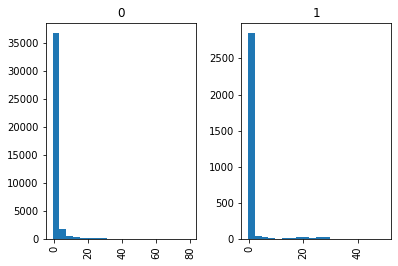

In [19]:
df.hist(column='diff_in_days',by='Car_Cancellation',xlabelsize=10 ,bins=20)

**We observe that the biggest possibility to cancel a drive increases about 3% (10%), when the diff_in_days is less than 8 hours(diff_in_days<0.3).So we insert a binary column which has that information**

In [20]:
c1=0
c2=0
small_diff = []
for i,j in zip(df.diff_in_days,df.Car_Cancellation):
    if i<0.3 :
        small_diff.append(1)
    else:
        small_diff.append(0)
df.insert(6, 'small_diff_in_days', small_diff)
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,small_diff_in_days,diff_in_days,from_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,28,2.03,83.0,448.0,15.0,1,0.014583,2013-01-01 02:00:00,0,0,12.924150,77.672290,12.927320,77.635750,0,1.0,0,1,0,0,1,0
1,0.439237,12,2.03,1010.0,540.0,15.0,1,0.274306,2013-01-01 09:00:00,0,0,12.966910,77.749350,12.927680,77.626640,0,1.0,0,1,0,0,1,0
2,0.454941,12,2.03,1301.0,1034.0,15.0,1,0.015278,2013-01-01 03:30:00,0,0,12.937222,77.626915,13.047926,77.597766,0,1.0,0,1,0,0,1,0
3,0.267233,12,2.03,768.0,398.0,15.0,1,0.045833,2013-01-01 05:45:00,0,0,12.989990,77.553320,12.971430,77.639140,0,1.0,0,1,0,0,1,0
4,0.454982,12,2.03,1365.0,849.0,15.0,1,0.046528,2013-01-01 09:00:00,0,0,12.845653,77.677925,12.954340,77.600720,0,1.0,0,1,0,0,1,0


## ANALYSING ONLINE_BOOKING

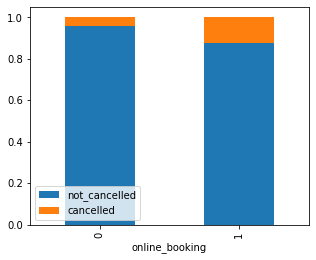

                not_cancelled  cancelled
online_booking                          
0                    0.956358   0.043642
1                    0.875377   0.124623


In [21]:
ax=pd.crosstab(df.online_booking,df.Car_Cancellation,normalize='index')
ax.columns=['not_cancelled','cancelled']
ax.plot(kind='bar',stacked=True,figsize=(5,4))

plt.show()
print(ax)

## ANALYSING MOBILE_SITE_BOOKING

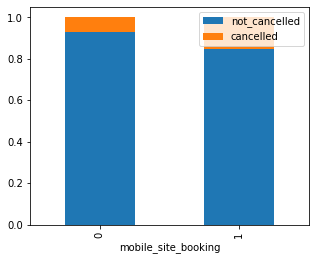

                     not_cancelled  cancelled
mobile_site_booking                          
0                         0.931581   0.068419
1                         0.846113   0.153887


In [22]:
ax=pd.crosstab(df.mobile_site_booking,df.Car_Cancellation,normalize='index')
ax.columns=['not_cancelled','cancelled']
ax.plot(kind='bar',stacked=True,figsize=(5,4))

plt.show()
print(ax)

**We observe that mobile_site_booking have double possibility to get canceled** 

## ANALYSING VEHICLE_MODEL_ID

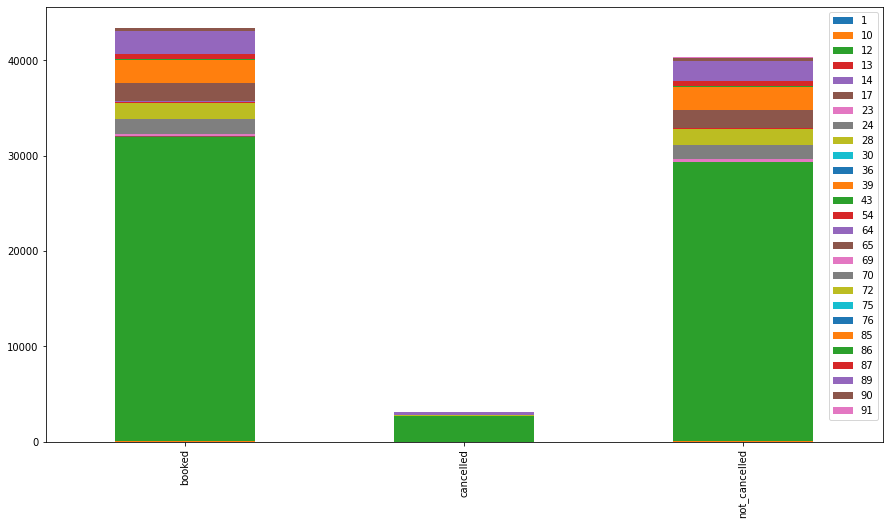

In [23]:
#Analysing vehicle_model_id
all_bookings=df['vehicle_model_id'].value_counts()
cancelled=df[df['Car_Cancellation']==1]['vehicle_model_id'].value_counts()
not_cancelled=df[df['Car_Cancellation']==0]['vehicle_model_id'].value_counts()
qf=pd.DataFrame([all_bookings,cancelled,not_cancelled])
#qf.fillna(0,inplace=True)
qf.index=['booked','cancelled','not_cancelled']
qf.plot(kind='bar',stacked=True,figsize=(15,8))
plt.show()

## ANALYSING PACKAGE_ID

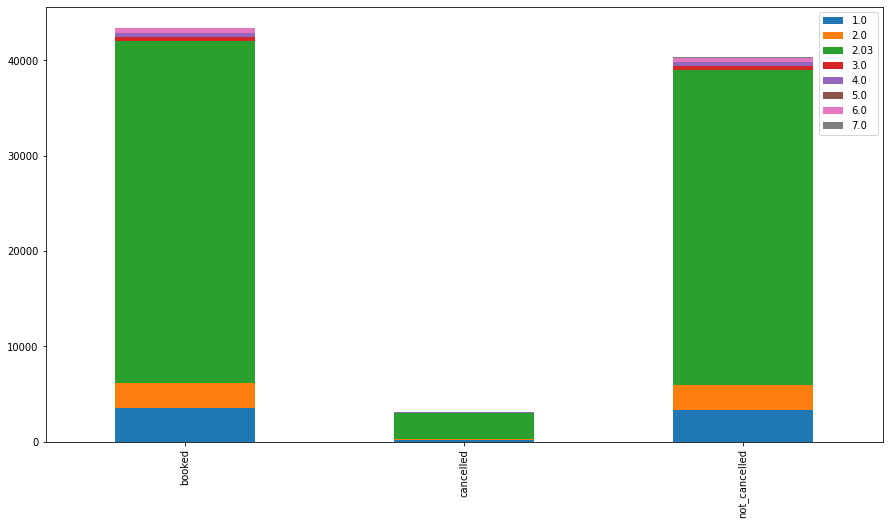

In [24]:
#Analysing package_id
all_bookings=df['package_id'].value_counts()
cancelled=df[df['Car_Cancellation']==1]['package_id'].value_counts()
not_cancelled=df[df['Car_Cancellation']==0]['package_id'].value_counts()
qf=pd.DataFrame([all_bookings,cancelled,not_cancelled])
#qf.fillna(0,inplace=True)
qf.index=['booked','cancelled','not_cancelled']
qf.plot(kind='bar',stacked=True,figsize=(15,8))
plt.show()

## NORMALIZE VEHICLE_MODEL_ID AND PACKAGE_ID

In [25]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df[['vehicle_model_id']])
df_normalized = pd.DataFrame(np_scaled)
df['vehicle_model_id'] = df_normalized

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df[['package_id']])
df_normalized = pd.DataFrame(np_scaled)
df['package_id'] = df_normalized
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,small_diff_in_days,diff_in_days,from_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,448.0,15.0,1,0.014583,2013-01-01 02:00:00,0,0,12.924150,77.672290,12.927320,77.635750,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,540.0,15.0,1,0.274306,2013-01-01 09:00:00,0,0,12.966910,77.749350,12.927680,77.626640,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,1034.0,15.0,1,0.015278,2013-01-01 03:30:00,0,0,12.937222,77.626915,13.047926,77.597766,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,398.0,15.0,1,0.045833,2013-01-01 05:45:00,0,0,12.989990,77.553320,12.971430,77.639140,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,849.0,15.0,1,0.046528,2013-01-01 09:00:00,0,0,12.845653,77.677925,12.954340,77.600720,0,1.0,0,1,0,0,1,0


## CALCULATE KM FROM COORDINATES AND REPLACE THEM

In [26]:
km_list=[]
for i,j,k,l in zip(df['from_lat'],df['from_long'],df['to_lat'],df['to_long']):
    slat = radians(float(i))
    slon = radians(float(j))
    elat = radians(float(k))
    elon = radians(float(l))
    dist = np.round(6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon)),1)
    km_list.append(dist)
dist_in_km=pd.DataFrame({'dist_in_km': km_list})
dist_in_km.head()

,dist_in_km
0,4.0
1,14.0
2,12.7
3,9.5
4,14.7


In [27]:
#drop columns and insert dist_in_km

df= df.drop(['from_lat','from_long','to_lat','to_long'],axis=1)
df.insert(8, 'dist_in_km', dist_in_km)

**Calculate the mean of km to fill the NaNs**

In [28]:
count = 0
j=0
for i in df['dist_in_km']:
    if not(math.isnan(i)):
        j+=1
        count+=i
km_mean=np.round(count/j,1)
df['dist_in_km'].fillna(km_mean, inplace = True)
km_mean

17.4

In [ ]:
#print(df['dist_in_km'].min())
#f=df.groupby(['dist_in_km','Car_Cancellation']).size()
#f.head()

In [29]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,small_diff_in_days,diff_in_days,dist_in_km,from_date,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,448.0,15.0,1,0.014583,4.0,2013-01-01 02:00:00,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,540.0,15.0,1,0.274306,14.0,2013-01-01 09:00:00,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,1034.0,15.0,1,0.015278,12.7,2013-01-01 03:30:00,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,398.0,15.0,1,0.045833,9.5,2013-01-01 05:45:00,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,849.0,15.0,1,0.046528,14.7,2013-01-01 09:00:00,0,0,0,1.0,0,1,0,0,1,0


## FIND HOLIDAYS IN DATASET AND SET THEM AS AN INDEPENDENT VARIABLE

In [30]:
dates=[]
date =[]
for i in df['from_date']:
    date = [i.month,i.day]
    dates.append(date)

holidays=[[1,26],[8,15],[10,2],[4,22],[1,14],[4,24],[3,29],[5,24],[9,9],[10,14],[10,13],[11,24],[11,17],[12,25],[1,1]]

on_holidays=[]
for i in dates:
    if i in holidays:
        on_holidays.append(1)
    else:
        on_holidays.append(0)
on_holidays = pd.DataFrame({'On_holidays':on_holidays})
df.insert(8, 'On_holidays', on_holidays)
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,from_date,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,448.0,15.0,1,0.014583,1,4.0,2013-01-01 02:00:00,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,540.0,15.0,1,0.274306,1,14.0,2013-01-01 09:00:00,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,1034.0,15.0,1,0.015278,1,12.7,2013-01-01 03:30:00,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,398.0,15.0,1,0.045833,1,9.5,2013-01-01 05:45:00,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,849.0,15.0,1,0.046528,1,14.7,2013-01-01 09:00:00,0,0,0,1.0,0,1,0,0,1,0


## ANALYSING ON_HOLIDAYS VARIABLE

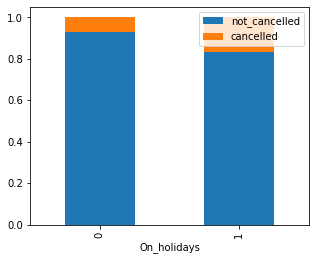

             not_cancelled  cancelled
On_holidays                          
0                 0.931562   0.068438
1                 0.835145   0.164855


In [31]:
ax=pd.crosstab(df.On_holidays,df.Car_Cancellation,normalize='index')
ax.columns=['not_cancelled','cancelled']
ax.plot(kind='bar',stacked=True,figsize=(5,4))

plt.show()
print(ax)

#big possibility to be cancelled on holidays

**Double possibility that a reservation was cancelled on holidays**

In [32]:
f=df.groupby(['On_holidays','Car_Cancellation']).size()
f

On_holidays  Car_Cancellation
0            0                   38916
             1                    2859
1            0                    1383
             1                     273
dtype: int64

In [33]:
df= df.drop(['from_date'],axis=1)

In [34]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,448.0,15.0,1,0.014583,1,4.0,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,540.0,15.0,1,0.274306,1,14.0,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,1034.0,15.0,1,0.015278,1,12.7,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,398.0,15.0,1,0.045833,1,9.5,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,849.0,15.0,1,0.046528,1,14.7,0,0,0,1.0,0,1,0,0,1,0


In [35]:
#might need it for plot distance km vs cancellations
f=pd.DataFrame({'dist_in_km': df.dist_in_km,'Car_Cancellation' : df.Car_Cancellation})
d=df.groupby(['dist_in_km','Car_Cancellation']).size()

for i,j,k in zip(f['dist_in_km'],f['Car_Cancellation'],d):
    if j==1 and k>20:
        print (i,j,k)

19.9 1 121


In [36]:
#drop to_area_id
df= df.drop(['to_area_id'],axis=1)


In [37]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,15.0,1,0.014583,1,4.0,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,15.0,1,0.274306,1,14.0,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,15.0,1,0.015278,1,12.7,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,15.0,1,0.045833,1,9.5,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,15.0,1,0.046528,1,14.7,0,0,0,1.0,0,1,0,0,1,0


## CALCULATE THE NUMBER OF REST OF NaNS AND THEM WE DROP THEM 

In [38]:
import math
count=0
for i in df.from_area_id:
    if math.isnan(i):
        count+=1
print(count)

88


In [39]:
#drop the rest of NaNs

df=df.dropna()
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,83.0,15.0,1,0.014583,1,4.0,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,1010.0,15.0,1,0.274306,1,14.0,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,1301.0,15.0,1,0.015278,1,12.7,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,768.0,15.0,1,0.045833,1,9.5,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,1365.0,15.0,1,0.046528,1,14.7,0,0,0,1.0,0,1,0,0,1,0


In [40]:
f=df.groupby(['from_area_id','Car_Cancellation']).size()
print (f)

from_area_id  Car_Cancellation
2.0           0                   27
              1                    4
6.0           0                    7
15.0          0                    6
16.0          0                    5
                                  ..
1399.0        0                   77
              1                    9
1401.0        0                    6
              1                    2
1403.0        0                    1
Length: 1002, dtype: int64


## NORMALIZE FROM_AREA_ID, to_city_id, dist_in_km

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df[['from_area_id','to_city_id','dist_in_km']])
df_normalized = pd.DataFrame(np_scaled)
df[['from_area_id','to_city_id','dist_in_km']] = df_normalized
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,0.057816,0.055276,1,0.014583,1,0.066890,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,0.719486,0.055276,1,0.274306,1,0.234114,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,0.927195,0.055276,1,0.015278,1,0.212375,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,0.546752,0.055276,1,0.045833,1,0.158863,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,0.972877,0.055276,1,0.046528,1,0.245819,0,0,0,1.0,0,1,0,0,1,0


In [ ]:
#min_max_scaler = preprocessing.MinMaxScaler()
#np_scaled = min_max_scaler.fit_transform(df[['from_area_id']])
#df_normalized = pd.DataFrame(np_scaled)
#df['from_area_id'] = df_normalized
#df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,0.057816,15.0,1,0.014583,1,4.0,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,0.719486,15.0,1,0.274306,1,14.0,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,0.927195,15.0,1,0.015278,1,12.7,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,0.546752,15.0,1,0.045833,1,9.5,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,0.972877,15.0,1,0.046528,1,14.7,0,0,0,1.0,0,1,0,0,1,0


In [42]:
#df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how='any',axis=0)
df


,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,0.057816,0.055276,1,0.014583,1,0.066890,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,0.719486,0.055276,1,0.274306,1,0.234114,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,0.927195,0.055276,1,0.015278,1,0.212375,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,0.546752,0.055276,1,0.045833,1,0.158863,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,0.972877,0.055276,1,0.046528,1,0.245819,0,0,0,1.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43338,0.597015,0.122222,0.166667,0.817273,0.055276,0,1.697917,0,0.178930,0,0,0,1.0,0,0,1,0,1,0
43339,0.368108,0.255556,0.171667,0.279086,0.055276,1,0.081250,0,0.356187,1,0,0,1.0,0,1,0,0,1,0
43340,0.592704,0.122222,0.171667,0.693790,0.055276,0,0.557639,1,0.290970,0,0,0,1.0,0,1,0,0,1,0
43341,0.309521,0.255556,0.166667,0.900071,0.055276,0,0.504861,1,0.076923,1,0,0,1.0,0,0,1,0,1,0


# PREDICTIVE MODELS EVALUATION

## LOGISTIC REGRESSION

In [43]:

#Very high accuracy, predicts only 0!

X = np.array([df.user_id,df.vehicle_model_id,df.package_id,df.from_area_id,df.to_city_id,df.small_diff_in_days,df.diff_in_days,df.On_holidays,df.dist_in_km,df.online_booking,df.mobile_site_booking,df.travel_type_1,df.travel_type_2,df.travel_type_3,df.from_city_1,df.from_city_15,df.from_city_31])
X=X.T
y=np.array(df.Car_Cancellation)
y.reshape((y.shape[0],1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
clf = linear_model.LogisticRegression(solver='sag',max_iter=400,tol=1e-6)
model=clf.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(clf.score(X_test, y_test))
r2score=r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')
print("R-Squared Score is: ",r2score)
print(y_pred)


0.9308750433475899
R-Squared Score is:  -0.07425804048180806
[0 0 0 ... 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


## DecisionTree with split (25%)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#regressor = RandomForestClassifier(n_estimators=100,random_state=0)  
regressor = DecisionTreeClassifier(random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))


[[9457  598]
 [ 546  213]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10055
           1       0.26      0.28      0.27       759

    accuracy                           0.89     10814
   macro avg       0.60      0.61      0.61     10814
weighted avg       0.90      0.89      0.90     10814

0.8942112076937303


## DecisionTree with 10-folds

In [58]:
X = np.array([df.user_id,df.vehicle_model_id,df.package_id,df.from_area_id,df.to_city_id,df.small_diff_in_days,df.diff_in_days,df.On_holidays,df.dist_in_km,df.online_booking,df.mobile_site_booking,df.travel_type_1,df.travel_type_2,df.travel_type_3,df.from_city_1,df.from_city_15,df.from_city_31])
X=X.T
y=np.array(df.Car_Cancellation)
y.reshape((y.shape[0],1))

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

skf = StratifiedKFold(n_splits=10)

# blank lists to store predicted values and actual values
predicted_y = []
expected_y = []
# partition data
for train_index, test_index in skf.split(X, y):

    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = DecisionTreeClassifier(random_state=0)  #80% with 643 correct cancellation
    #clf=RandomForestClassifier(n_estimators=100,random_state=0)  #86% with 416 correct cancellation 
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test) 
    
    predicted_y.extend(clf.predict(X_test))
    # store expected result for this specific fold
    expected_y.extend(y_test)



print(confusion_matrix(expected_y,predicted_y))  
print(classification_report(expected_y,predicted_y))  
print(accuracy_score(expected_y,predicted_y)) 

# confusion matrix :   [true positives     false negatives
#                       false positives    true negatives]
#true positives = correct 0
#false positives = wrong 0
#false negative = wrong 1
#true negatives = correct 1


#Precision -> 0:  true_positives/(true positives+false negatives) (column)
#             1:  true_negatives / (false_positives+true_negatives) 
#Recall ----> 0:  true_positives/support (row)
#-----------> 1:  true_negatives/support   AVG/TOTAL = total ACCURACY
# f1-score--> 0,1:  2*(precision *recall) / (precision +recall) (the higher the better)
# support --> total number of instances at each class

[ 4072  4073  4074 ... 43252 43253 43254] [    0     1     2 ... 11867 11868 11894]
[    0     1     2 ... 43252 43253 43254] [ 4072  4073  4074 ... 14437 14440 14441]
[    0     1     2 ... 43252 43253 43254] [ 8170  8171  8172 ... 16313 16318 16325]
[    0     1     2 ... 43252 43253 43254] [12391 12392 12393 ... 25519 25618 25832]
[    0     1     2 ... 43252 43253 43254] [17091 17092 17093 ... 31850 31872 31883]
[    0     1     2 ... 43252 43253 43254] [21232 21233 21234 ... 35010 35037 35047]
[    0     1     2 ... 43252 43253 43254] [25327 25328 25329 ... 37735 37736 37739]
[    0     1     2 ... 43252 43253 43254] [29541 29542 29543 ... 40109 40115 40132]
[    0     1     2 ... 43252 43253 43254] [33924 33925 33926 ... 41228 41233 41234]
[    0     1     2 ... 41228 41233 41234] [38421 38422 38423 ... 43252 43253 43254]
[[33603  6535]
 [ 2578   539]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     40138
           1       0

## Random Forest with split

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

regressor = RandomForestClassifier(n_estimators=100,random_state=0)  
#regressor = DecisionTreeClassifier(random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))


[[9958   97]
 [ 634  125]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10055
           1       0.56      0.16      0.25       759

    accuracy                           0.93     10814
   macro avg       0.75      0.58      0.61     10814
weighted avg       0.91      0.93      0.91     10814

0.9324024412798224


## Random Forest with 10-folds

In [60]:
X = np.array([df.user_id,df.vehicle_model_id,df.package_id,df.from_area_id,df.to_city_id,df.small_diff_in_days,df.diff_in_days,df.On_holidays,df.dist_in_km,df.online_booking,df.mobile_site_booking,df.travel_type_1,df.travel_type_2,df.travel_type_3,df.from_city_1,df.from_city_15,df.from_city_31])
X=X.T
y=np.array(df.Car_Cancellation)
y.reshape((y.shape[0],1))

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

skf = StratifiedKFold(n_splits=10)

# blank lists to store predicted values and actual values
predicted_y = []
expected_y = []
# partition data
for train_index, test_index in skf.split(X, y):

    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #clf = DecisionTreeClassifier(random_state=0)  #80% with 643 correct cancellation
    clf=RandomForestClassifier(n_estimators=100,random_state=0)  #86% with 416 correct cancellation 
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test) 
    # create and fit classifier
    #clf = linear_model.LogisticRegression(solver='sag',max_iter=600,tol=1e-4)
   # clf.fit(x_train,Y_train)
    # store result from classification
    predicted_y.extend(clf.predict(X_test))
    # store expected result for this specific fold
    expected_y.extend(y_test)




print(confusion_matrix(expected_y,predicted_y))  
print(classification_report(expected_y,predicted_y))  
print(accuracy_score(expected_y,predicted_y)) 

[ 4072  4073  4074 ... 43252 43253 43254] [    0     1     2 ... 11867 11868 11894]
[    0     1     2 ... 43252 43253 43254] [ 4072  4073  4074 ... 14437 14440 14441]
[    0     1     2 ... 43252 43253 43254] [ 8170  8171  8172 ... 16313 16318 16325]
[    0     1     2 ... 43252 43253 43254] [12391 12392 12393 ... 25519 25618 25832]
[    0     1     2 ... 43252 43253 43254] [17091 17092 17093 ... 31850 31872 31883]
[    0     1     2 ... 43252 43253 43254] [21232 21233 21234 ... 35010 35037 35047]
[    0     1     2 ... 43252 43253 43254] [25327 25328 25329 ... 37735 37736 37739]
[    0     1     2 ... 43252 43253 43254] [29541 29542 29543 ... 40109 40115 40132]
[    0     1     2 ... 43252 43253 43254] [33924 33925 33926 ... 41228 41233 41234]
[    0     1     2 ... 41228 41233 41234] [38421 38422 38423 ... 43252 43253 43254]
[[37037  3101]
 [ 2781   336]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     40138
           1       0

## K-N-N MODEL WITH SPLIT

In [61]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

regressor = KNeighborsClassifier()  
#regressor = DecisionTreeClassifier(random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))



[[9895  160]
 [ 662   97]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10055
           1       0.38      0.13      0.19       759

    accuracy                           0.92     10814
   macro avg       0.66      0.56      0.58     10814
weighted avg       0.90      0.92      0.91     10814

0.9239874237100055


## K-N-N MODEL WITH 10-FOLDS

In [62]:
skf = StratifiedKFold(n_splits=10)

# blank lists to store predicted values and actual values
predicted_y = []
expected_y = []
# partition data
for train_index, test_index in skf.split(X, y):

    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #clf = DecisionTreeClassifier(random_state=0)  #80% me 643 correct cancellation
    clf=KNeighborsClassifier()  #86% me 416 correct cancellation 
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test) 
    # create and fit classifier
    #clf = linear_model.LogisticRegression(solver='sag',max_iter=600,tol=1e-4)
   # clf.fit(x_train,Y_train)
    # store result from classification
    predicted_y.extend(clf.predict(X_test))
    # store expected result for this specific fold
    expected_y.extend(y_test)




print(confusion_matrix(expected_y,predicted_y))  
print(classification_report(expected_y,predicted_y))  
print(accuracy_score(expected_y,predicted_y))

[ 4072  4073  4074 ... 43252 43253 43254] [    0     1     2 ... 11867 11868 11894]
[    0     1     2 ... 43252 43253 43254] [ 4072  4073  4074 ... 14437 14440 14441]
[    0     1     2 ... 43252 43253 43254] [ 8170  8171  8172 ... 16313 16318 16325]
[    0     1     2 ... 43252 43253 43254] [12391 12392 12393 ... 25519 25618 25832]
[    0     1     2 ... 43252 43253 43254] [17091 17092 17093 ... 31850 31872 31883]
[    0     1     2 ... 43252 43253 43254] [21232 21233 21234 ... 35010 35037 35047]
[    0     1     2 ... 43252 43253 43254] [25327 25328 25329 ... 37735 37736 37739]
[    0     1     2 ... 43252 43253 43254] [29541 29542 29543 ... 40109 40115 40132]
[    0     1     2 ... 43252 43253 43254] [33924 33925 33926 ... 41228 41233 41234]
[    0     1     2 ... 41228 41233 41234] [38421 38422 38423 ... 43252 43253 43254]
[[39097  1041]
 [ 2743   374]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     40138
           1       0

## GRADIENT BOOSTING CLASSIFIER WITH SPLIT

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

regressor = GradientBoostingClassifier(subsample=0.8,learning_rate=0.2,n_estimators=140,max_depth=4)  
#regressor = DecisionTreeClassifier(random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test) 
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[9942  113]
 [ 616  143]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10055
           1       0.56      0.19      0.28       759

    accuracy                           0.93     10814
   macro avg       0.75      0.59      0.62     10814
weighted avg       0.91      0.93      0.92     10814

0.9325873867209173


In [64]:
df.head()

,user_id,vehicle_model_id,package_id,from_area_id,to_city_id,small_diff_in_days,diff_in_days,On_holidays,dist_in_km,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error,travel_type_1,travel_type_2,travel_type_3,from_city_1,from_city_15,from_city_31
0,0.454921,0.300000,0.171667,0.057816,0.055276,1,0.014583,1,0.066890,0,0,0,1.0,0,1,0,0,1,0
1,0.439237,0.122222,0.171667,0.719486,0.055276,1,0.274306,1,0.234114,0,0,0,1.0,0,1,0,0,1,0
2,0.454941,0.122222,0.171667,0.927195,0.055276,1,0.015278,1,0.212375,0,0,0,1.0,0,1,0,0,1,0
3,0.267233,0.122222,0.171667,0.546752,0.055276,1,0.045833,1,0.158863,0,0,0,1.0,0,1,0,0,1,0
4,0.454982,0.122222,0.171667,0.972877,0.055276,1,0.046528,1,0.245819,0,0,0,1.0,0,1,0,0,1,0
